#Unsupervised Analysis

In [8]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
from time import time

In [9]:
#Read in yearly data
YearDat = pd.read_csv('YearDat.csv')

In [11]:
#Get only complete observations
#This reduces the sample down to 80 cities only...
a = YearDat[['CBSA Name','PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]
a = a.dropna()
b = a [['PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]

In [53]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
import scipy.cluster.hierarchy as hac
X = np.array(b)
Z = hac.linkage(X, 'average')

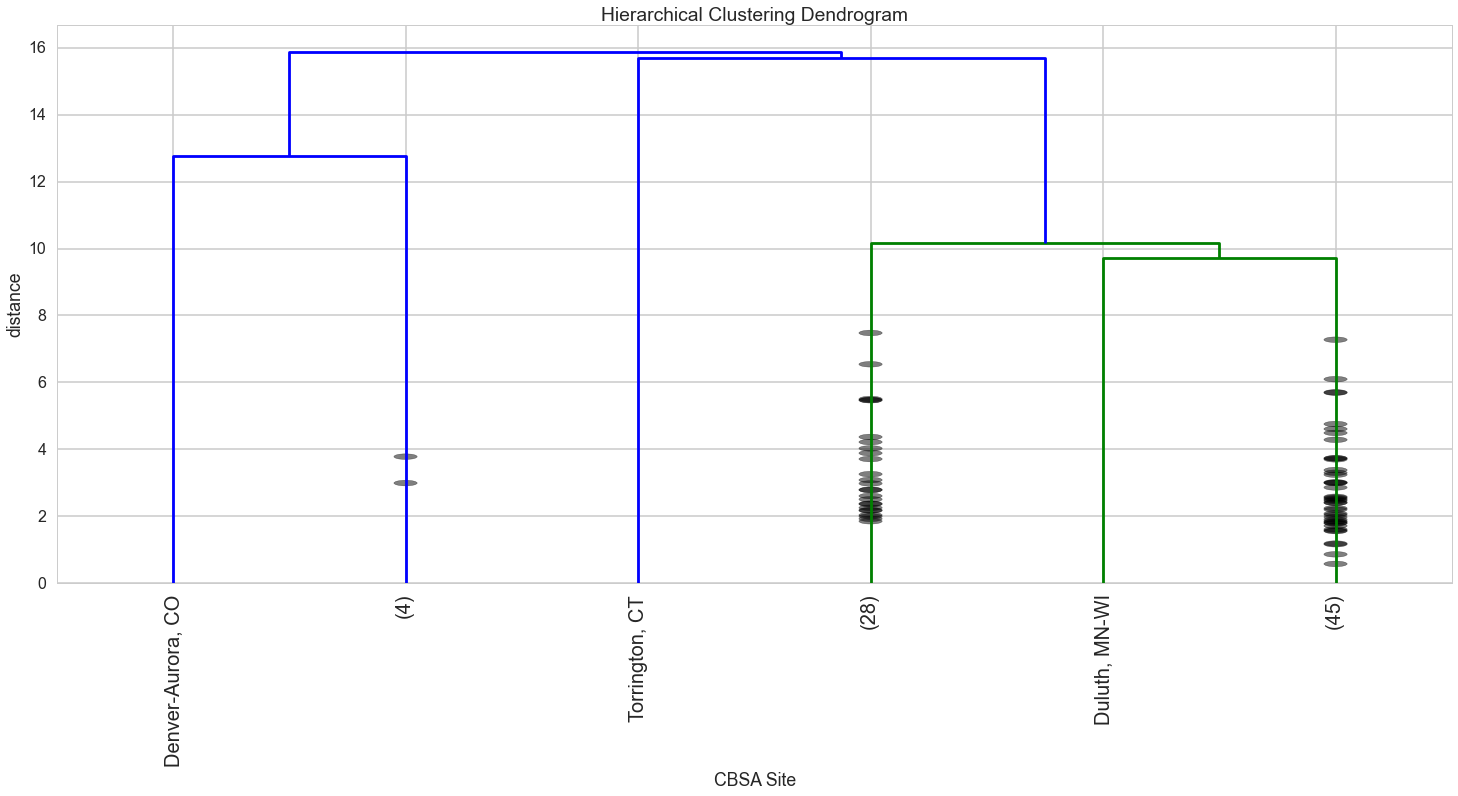

In [64]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('CBSA Site')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    truncate_mode='lastp',
    p=6,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    show_contracted=True,
    labels = np.array(a['CBSA Name'])
)
plt.show()

In [75]:
#More from 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import fcluster
max_d = 9
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 1, 2, 4, 3, 5, 1, 3, 4, 4,
       3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 4,
       3, 1, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 1, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3,
       4, 6, 3, 4, 4, 4, 3, 4, 4, 4, 3])

In [76]:
a['label']=clusters

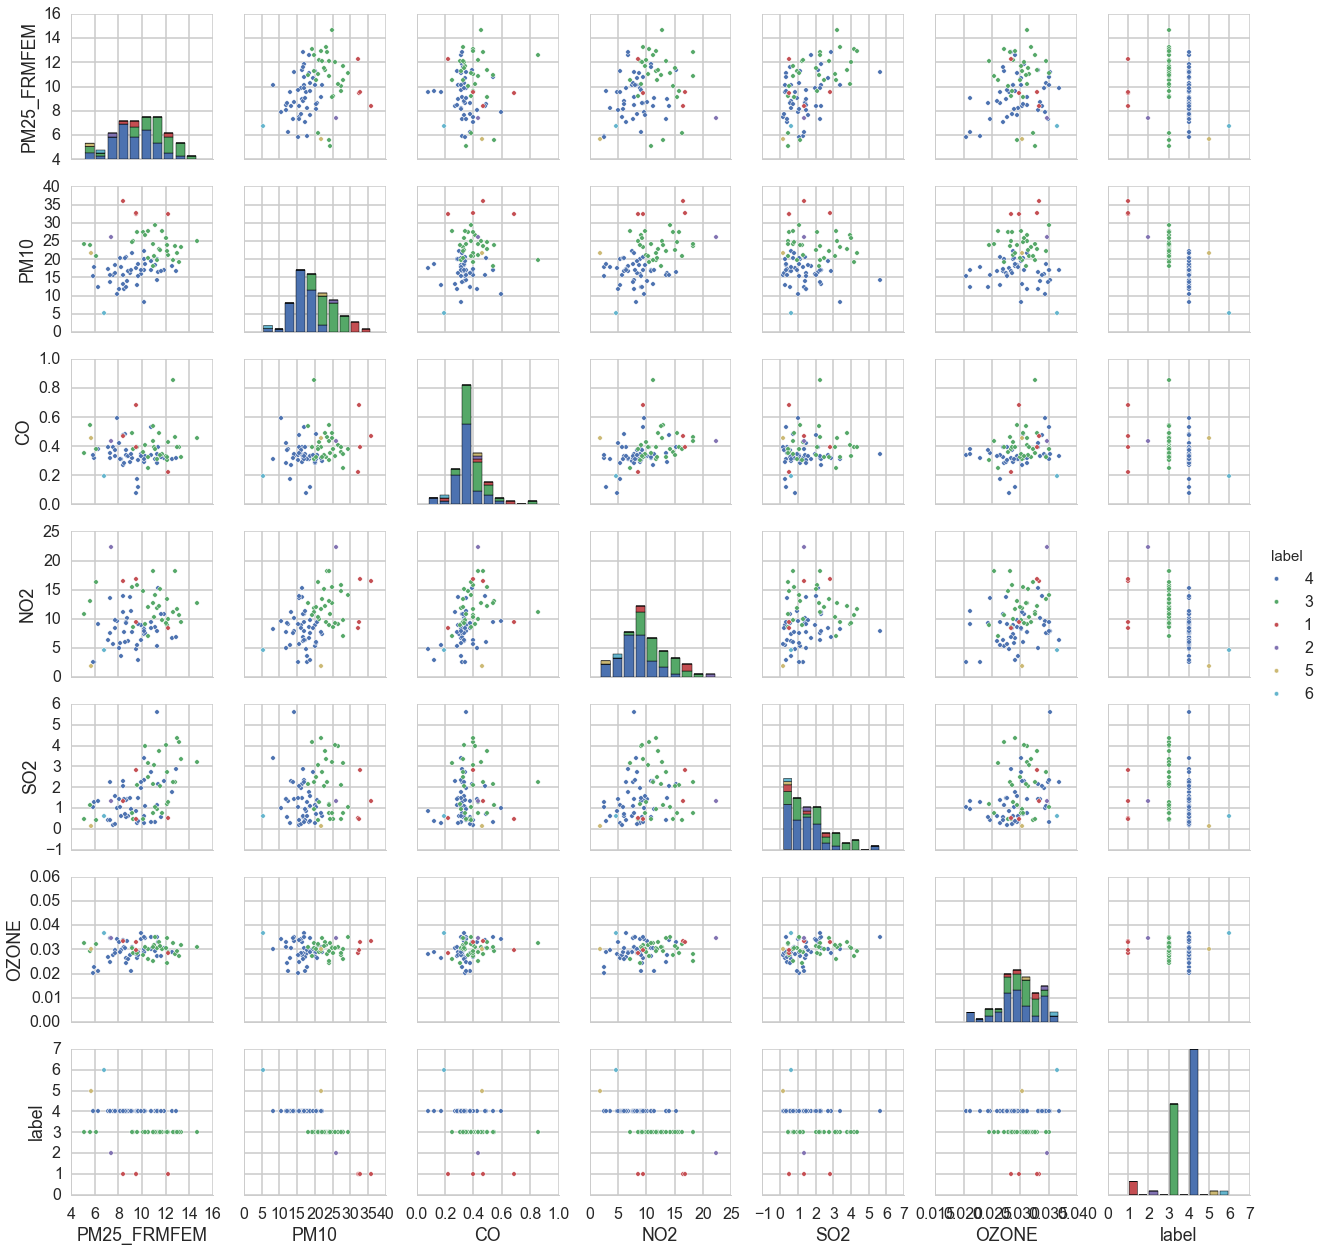

In [77]:
sns.pairplot(a, hue="label")

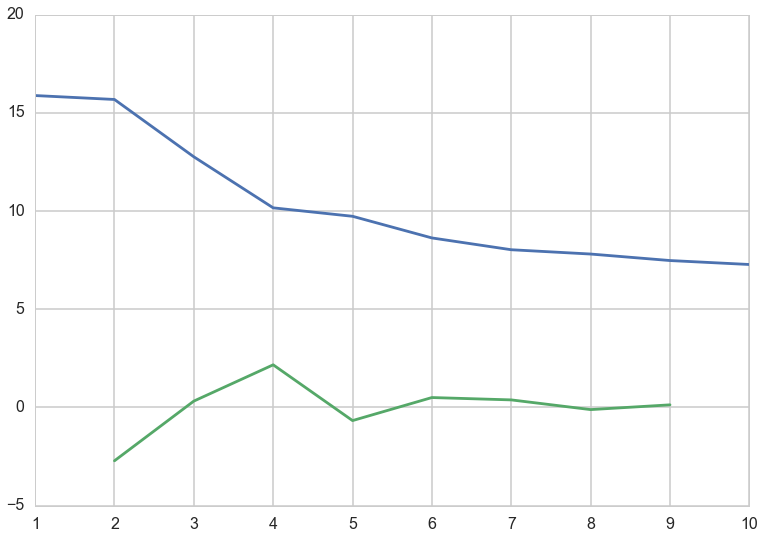

clusters: 4


In [65]:
#More from 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

In [42]:
import random
lad = []
for i in range(80):
    q = random.random()
    if q <= 0.2:
        lad.append(1)
    elif (q > 0.2) and (q<=0.5):
        lad.append(2)
    elif (q > 0.5) and (q<=1):
        lad.append(3)

In [48]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_samples, n_features = b.shape
n_digits = 3
labels = lad

sample_size = 60

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 3, 	 n_samples 80, 	 n_features 6


In [49]:
n_digits

3

In [50]:
print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')

_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette


In [51]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=b)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=b)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(b)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=b)
print(79 * '_')

IndexError: indices are out-of-bounds

n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.20s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.18s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.02s    71820   0.673   0.715   0.693   0.567   0.670    0.150
_______________________________________________________________________________


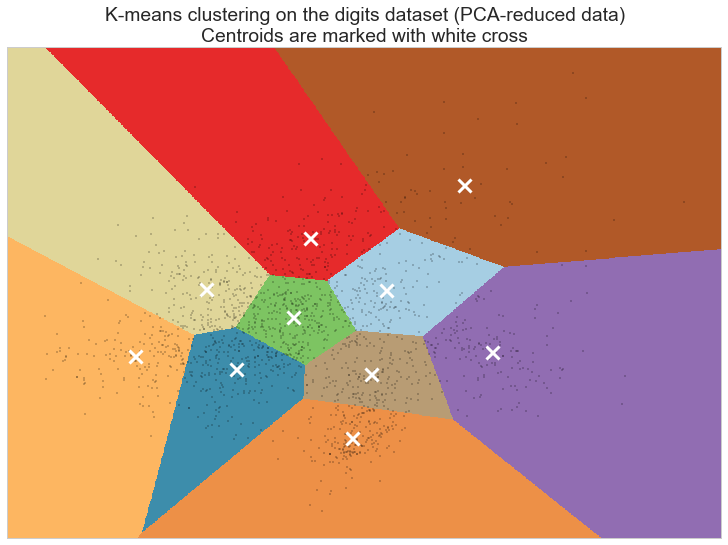

In [46]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [47]:
labels

array([0, 1, 2, ..., 8, 9, 8])